In [1]:
from utils.binaries import *
from utils.plotting import *

import polars as pl

20:05:22 (   +5.7s) [INFO   ] -- import logging
20:05:23 (  +110ms) [INFO   ] -- import numpy as np
20:05:23 (    +9ms) [INFO   ] -- import uncertainties
20:05:23 (  +714ms) [INFO   ] -- import pandas as pd
20:05:23 (    +5ms) [WARNING] -- pandas support to be dropped at some point!
20:05:23 (    +8ms) [INFO   ] -- import binaries.tools as tools
20:05:24 (  +943ms) [INFO   ] -- import matplotlib.pyplot as plt
20:05:25 (  +748ms) [INFO   ] -- import seaborn as so
20:05:25 (   +17ms) [DEBUG  ] -- font size set to 9.5
20:05:25 (    +1ms) [DEBUG  ] -- label size set to 13.0
20:05:25 (    +3ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
20:05:25 (    +0ms) [DEBUG  ] -- markersize set to 2.0
20:05:25 (    +2ms) [DEBUG  ] -- usetex set to False
20:05:25 (   +19ms) [INFO   ] -- import plotting.tools as plot


In [2]:
# T3 histo files
t3_histos = pl.read_csv('/cr/users/filip/Data/muonAcquisition/T3events/night/t3_histos.txt',
                        has_header=False,
                        new_columns=['id', 't'],
                        separator=' ')

t3_histos = t3_histos.with_columns(
    histo=pl.concat_list(pl.exclude('id', 't'))
).select('id', 't', 'histo')

t3_histos

id,t,histo
i64,i64,list[i64]
1840,1398069000,"[1, 1089, … 0]"
1823,1398069011,"[0, 66, … 0]"
660,1398069011,"[0, 842, … 0]"
1845,1398069011,"[2, 1071, … 1]"
1839,1398069011,"[0, 742, … 0]"
…,…,…
1845,1398077151,"[0, 1066, … 0]"
1839,1398077144,"[1, 1190, … 0]"
643,1398077132,"[0, 0, … 0]"


In [9]:
# muonAcq histos

import os

def read_file(path):

    path = f'/cr/users/filip/Data/muonAcquisition/night/' + path
    coinc_hist = lambda x : [int(e.split(' ')[-4]) for e in x] # ...
    all_hist = lambda x : [int(e.split(' ')[-1]) for e in x]
    peak_histo, rates = [], []

    with open(path, 'r') as source:

        baseline = 0

        is_peak_histogram = False
        is_all_histogram = False
        for i, line in enumerate(source.readlines()):
            line = line.strip()

            if line.startswith('Offset'):
                baseline = int(line.split(' ')[-1])

            if line == 'Peak': 
                is_peak_histogram = True
                continue
            elif line == 'Charge':
                is_peak_histogram = False
            
            if is_peak_histogram: peak_histo.append(line)
            if line == '======ssd:':
                is_all_histogram = True
                continue

            if is_all_histogram: rates.append(line)

        peak_histo = np.array(coinc_hist(peak_histo))
        bin0 = int(rates[0].split(' ')[3])

    return peak_histo, all_hist(rates[1:]), bin0 - baseline


peak_histos = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
all_histos = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
offsets = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
for i, file in enumerate(os.listdir(f'/cr/users/filip/Data/muonAcquisition/night/')):

    timestamp, station = file.split('_')
    peak_hist, all_hist, offset = read_file(file)
    peak_histos[station].append(peak_hist)
    all_histos[station].append(all_hist)
    offsets[station].append(offset)

(0.0, 300.0)

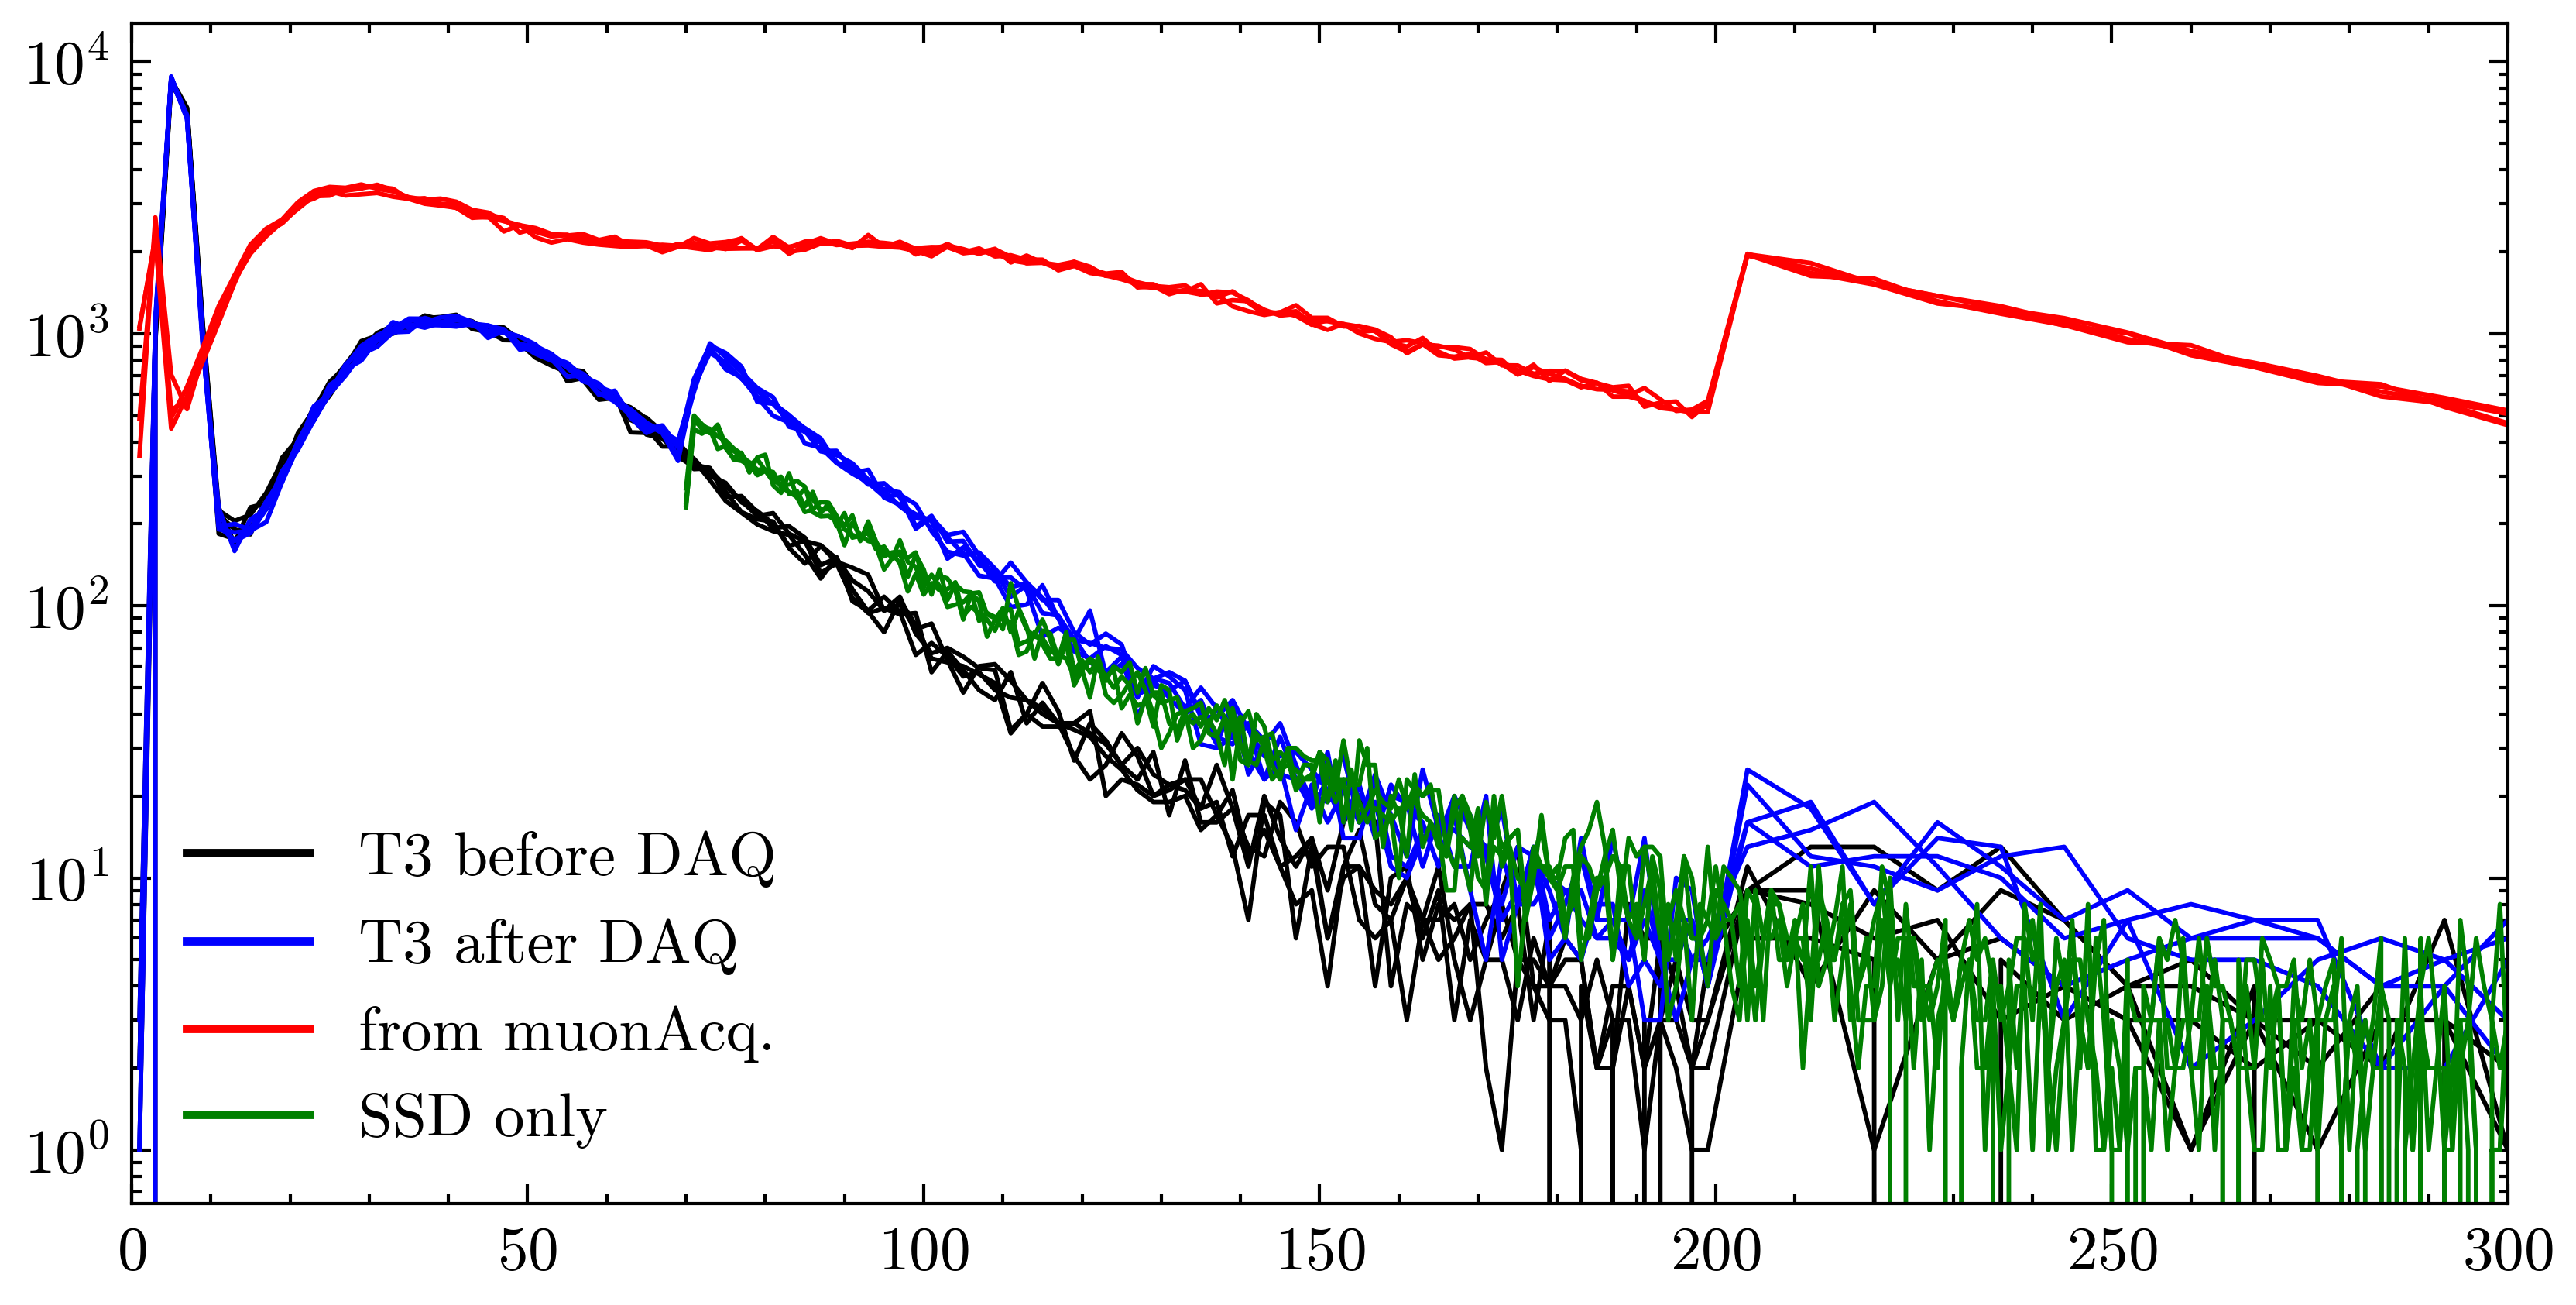

In [21]:
SSD_PEAK_HISTO_BINNING = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
SSD_HISTO_BIN_CENTERS = 0.5 * (SSD_PEAK_HISTO_BINNING[1:] + SSD_PEAK_HISTO_BINNING[:-1])

id = 1845
linewidth = 0.7

for event in t3_histos.iter_rows():
    if event[0] != id: continue

    color = 'blue' if event[1] > 1398070000 else 'k'

    plt.plot(SSD_HISTO_BIN_CENTERS, event[2], c=color, ls='solid', lw=linewidth)

for station in list(peak_histos.keys()):
    if station != str(id): continue

    peak_hists, all_hists, offs = peak_histos[station], all_histos[station], offsets[station]

    for peak, _all, o in zip(peak_hists, all_hists, offs):
        try:
            plt.plot(SSD_HISTO_BIN_CENTERS, peak, c='r', ls='solid', lw=linewidth)
            plt.plot(range(o, o + len(_all)), _all, c='green', ls='solid', lw=linewidth)
        except ValueError: continue

plt.plot([],[], c='k', lw=1.3, ls='solid', label='T3 before DAQ')
plt.plot([],[], c='b', lw=1.3, ls='solid', label='T3 after DAQ')
plt.plot([],[], c='r', lw=1.3, ls='solid', label='from muonAcq.')
plt.plot([],[], c='g', lw=1.3, ls='solid', label='SSD only')
plt.legend()
plt.yscale('log')
plt.xlim(0, 300)
